## **Import Library** 

In [1]:
# -------------------------------
# Library yang sering digunakan
# -------------------------------
import os
import shutil
import zipfile
import random
from random import sample
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

# -------------------------------------
# Libraries untuk pemrosesan data gambar
# -------------------------------------
import cv2
from PIL import Image
import skimage
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# --------------------------------
# Libraries untuk pembangunan model
# --------------------------------
# Mengatur agar TensorFlow hanya menampilkan log error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Library dari scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Library dari TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D  # Untuk model EfficientNetB0
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Library untuk model berbasis EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------------
# Konfigurasi Warning
# -------------------------------
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


E0000 00:00:1747812166.434120      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747812166.497976      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Load Dataset**

In [2]:
# Tentukan direktori dataset split
train_dir = "/kaggle/input/garbage-classification/fix-final-garbage-dataset/train"
val_dir   = "/kaggle/input/garbage-classification/fix-final-garbage-dataset/validation"
test_dir  = "/kaggle/input/garbage-classification/fix-final-garbage-dataset/test"

# Buat ImageDataGenerator untuk masing-masing dataset; rescale untuk normalisasi
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen   = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)


## **Modelling**

In [3]:
# Data Generators with Preprocessing dan Augmentasi
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 4. Hitung Class Weights
y_train = train_set.classes
classes = np.unique(y_train)
computed_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, computed_weights))
print("Computed Class Weights:", class_weight_dict)

# 5. Transfer Learning: EfficientNetB0 sebagai Backbone
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze semua layer awal
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# 6. Compile Model Head-Only
opt = Adam(learning_rate=1e-4)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# 8. Training Phase 1: Train Head
history_phase1 = model.fit(
    train_set,
    epochs=5,
    validation_data=val_set,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=2
)

# 9. Unfreeze beberapa layer untuk Fine-Tuning
for layer in base_model.layers[-30:]:  # Unfreeze 30 layer terakhir
    layer.trainable = True

# 10. Compile Ulang untuk Fine-Tuning
tf_opt_finetune = Adam(learning_rate=1e-5)
model.compile(
    optimizer=tf_opt_finetune,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 11. Training Phase 2: Fine-Tuning
history_phase2 = model.fit(
    train_set,
    epochs=10,
    validation_data=val_set,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=2
)

# Evaluasi pada data training
train_loss, train_accuracy = model.evaluate(train_set, verbose=0)
print("Akurasi Data Training: {:.2f}%".format(train_accuracy * 100))

# Evaluasi pada data testing
test_loss, test_accuracy = model.evaluate(test_set, verbose=0)
print("Akurasi Data Testing: {:.2f}%".format(test_accuracy * 100))

Found 15342 images belonging to 10 classes.
Found 3307 images belonging to 10 classes.
Found 3321 images belonging to 10 classes.
Computed Class Weights: {0: 2.3245454545454547, 1: 2.201147776183644, 2: 0.646251053074979, 3: 1.2023510971786835, 4: 0.4115343347639485, 5: 0.7179223210107627, 6: 1.3068143100511074, 7: 1.2214968152866241, 8: 1.1093275488069414, 9: 2.3351598173515984}


I0000 00:00:1747812282.186907      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747812282.187735      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,386,221 (16.73 MB)

 Trainable params: 333,578 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1747812304.279801     119 service.cc:148] XLA service 0x7ea2b8051220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747812304.280635     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747812304.280656     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747812306.368092     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747812317.703650     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


480/480 - 235s - 490ms/step - accuracy: 0.7647 - loss: 0.8383 - val_accuracy: 0.9444 - val_loss: 0.2033
Epoch 2/5
480/480 - 59s - 122ms/step - accuracy: 0.9100 - loss: 0.3298 - val_accuracy: 0.9589 - val_loss: 0.1462
Epoch 3/5
480/480 - 58s - 122ms/step - accuracy: 0.9346 - loss: 0.2383 - val_accuracy: 0.9655 - val_loss: 0.1243
Epoch 4/5
480/480 - 61s - 127ms/step - accuracy: 0.9442 - loss: 0.2030 - val_accuracy: 0.9670 - val_loss: 0.1139
Epoch 5/5
480/480 - 56s - 118ms/step - accuracy: 0.9526 - loss: 0.1707 - val_accuracy: 0.9689 - val_loss: 0.1046
Epoch 1/10


E0000 00:00:1747812784.130091     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747812784.271688     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


480/480 - 119s - 248ms/step - accuracy: 0.8972 - loss: 0.3234 - val_accuracy: 0.9534 - val_loss: 0.1522
Epoch 2/10
480/480 - 60s - 124ms/step - accuracy: 0.9190 - loss: 0.2676 - val_accuracy: 0.9592 - val_loss: 0.1317
Epoch 3/10
480/480 - 59s - 124ms/step - accuracy: 0.9296 - loss: 0.2231 - val_accuracy: 0.9634 - val_loss: 0.1209
Epoch 4/10
480/480 - 57s - 120ms/step - accuracy: 0.9395 - loss: 0.2011 - val_accuracy: 0.9661 - val_loss: 0.1126
Epoch 5/10
480/480 - 59s - 123ms/step - accuracy: 0.9417 - loss: 0.1913 - val_accuracy: 0.9670 - val_loss: 0.1083
Epoch 6/10
480/480 - 58s - 120ms/step - accuracy: 0.9491 - loss: 0.1729 - val_accuracy: 0.9695 - val_loss: 0.1035
Epoch 7/10
480/480 - 59s - 123ms/step - accuracy: 0.9506 - loss: 0.1593 - val_accuracy: 0.9713 - val_loss: 0.0988
Epoch 8/10
480/480 - 63s - 131ms/step - accuracy: 0.9552 - loss: 0.1474 - val_accuracy: 0.9722 - val_loss: 0.0964
Epoch 9/10
480/480 - 65s - 135ms/step - accuracy: 0.9566 - loss: 0.1415 - val_accuracy: 0.9740 - v

## **Visualisasi**

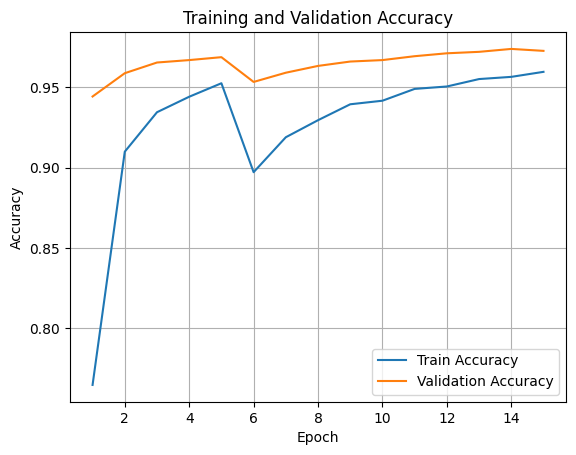

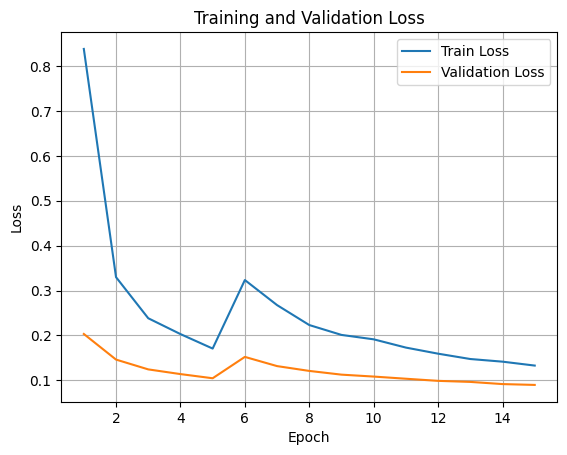

In [4]:
def plot_training_history(history1, history2=None, phase_names=None):
    """
    Plot training & validation accuracy and loss.
    
    Parameters:
    - history1: History object dari phase 1 (head-only).
    - history2: (Optional) History object dari phase 2 (fine-tuning).
    - phase_names: (Optional) List of names untuk tiap phase, e.g. ['Phase 1', 'Phase 2'].
    """
    # Siapkan data
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']
    
    # Jika ada phase kedua, tambahkan di belakang phase pertama
    if history2 is not None:
        acc2 = history2.history['accuracy']
        val_acc2 = history2.history['val_accuracy']
        loss2 = history2.history['loss']
        val_loss2 = history2.history['val_loss']
        
        acc = acc1 + acc2
        val_acc = val_acc1 + val_acc2
        loss = loss1 + loss2
        val_loss = val_loss1 + val_loss2
        
        # Epoch numbering
        epochs = list(range(1, len(acc1) + len(acc2) + 1))
    else:
        acc, val_acc = acc1, val_acc1
        loss, val_loss = loss1, val_loss1
        epochs = list(range(1, len(acc1) + 1))
    
    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Loss
    plt.figure()
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----- Contoh penggunaan setelah training -----
# Fase 1 (head-only) sudah dijalankan:
# history_phase1 = model.fit( ... )

# Fase 2 (fine-tuning) sudah dijalankan:
# history_phase2 = model.fit( ... )

# Panggil fungsi visualisasi:
plot_training_history(history_phase1, history_phase2, phase_names=['Head-Only', 'Fine-Tune'])


## **Export Model**

In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 7. Callbacks dengan ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    'best_model.h5',              # nama file untuk menyimpan model terbaik
    monitor='val_accuracy',       # metric yang dipantau
    save_best_only=True,          # hanya save bila ada perbaikan
    mode='max',
    verbose=1
)

# 8. Training Phase 1: Train Head dengan checkpoint
history_phase1 = model.fit(
    train_set,
    epochs=5,
    validation_data=val_set,
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

# 9. Unfreeze beberapa layer untuk Fine-Tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 10. Compile Ulang untuk Fine-Tuning
tf_opt_finetune = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=tf_opt_finetune,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 11. Training Phase 2: Fine-Tuning dengan checkpoint
history_phase2 = model.fit(
    train_set,
    epochs=10,
    validation_data=val_set,
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

# Setelah training selesai, file 'best_model.h5' berisi bobot model dengan val_accuracy tertinggi.

# 12. Konversi ke TensorFlow Lite
# ------------------------------------------------
# 12.1 Load model terbaik
best_model = tf.keras.models.load_model('best_model.h5')

# 12.2 Buat converter TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# (Opsional) Tambahkan optimisasi, misalnya dynamic range quantization:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# 12.3 Simpan file .tflite
with open('model_best.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model terbaik berhasil disimpan sebagai model_best.tflite")


Epoch 1/5

Epoch 1: val_accuracy improved from -inf to 0.97430, saving model to best_model.h5
480/480 - 59s - 123ms/step - accuracy: 0.9617 - loss: 0.1304 - val_accuracy: 0.9743 - val_loss: 0.0891
Epoch 2/5

Epoch 2: val_accuracy improved from 0.97430 to 0.97490, saving model to best_model.h5
480/480 - 58s - 121ms/step - accuracy: 0.9582 - loss: 0.1311 - val_accuracy: 0.9749 - val_loss: 0.0872
Epoch 3/5

Epoch 3: val_accuracy improved from 0.97490 to 0.97551, saving model to best_model.h5
480/480 - 60s - 124ms/step - accuracy: 0.9664 - loss: 0.1162 - val_accuracy: 0.9755 - val_loss: 0.0852
Epoch 4/5

Epoch 4: val_accuracy improved from 0.97551 to 0.97581, saving model to best_model.h5
480/480 - 62s - 129ms/step - accuracy: 0.9655 - loss: 0.1103 - val_accuracy: 0.9758 - val_loss: 0.0842
Epoch 5/5

Epoch 5: val_accuracy improved from 0.97581 to 0.97611, saving model to best_model.h5
480/480 - 59s - 122ms/step - accuracy: 0.9662 - loss: 0.1108 - val_accuracy: 0.9761 - val_loss: 0.0812
Epo

W0000 00:00:1747814414.474466      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747814414.474503      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747814414.668475      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Model terbaik berhasil disimpan sebagai model_best.tflite
